In [3]:
import sys; sys.path.append('/sj0243/')

In [11]:
from python_for_nustar.pyxspec_lib.nustar_xspec import scan_containers_ph_res, query_par, ph_res_param, Model, Fit, Plot, xspec,  AllModels
from python_for_nustar.nu_core import set_mpl#plot_spe_ratio, 
from python_for_nustar.nu_class import NustarObservation, glob
from python_for_nustar.pipeline.sj0243_init import Nu_path, ObsList_bright, plot_path, ObsAlias
set_mpl('mallsoft')

xspec.AllModels.lmod('relxill', '/sj0243/python_for_nustar/relxill_model/')


def pf_and_relative_var(observable):
    o_min = np.min(observable)
    o_max = np.max(observable)
    pf = (o_max-o_min)/(o_max+o_min)
    rel = o_max/o_min - 1 
    return pf, rel

def plot_results(ObsID, model = 'relxilllp', plot_refl_flux = True):

    fig = plt.figure(figsize=(6, 6))
    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)
    rows, cols = 5,  1
    # (rows,cols), (y,x) <- those are coordinates of an axis in subplots
    ax1 = plt.subplot2grid((rows, cols), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((rows, cols), (1, 0), rowspan=1, colspan=1, sharex = ax1)
    ax3 = plt.subplot2grid((rows, cols), (2, 0), rowspan=1, colspan=1, sharex = ax1)
    ax4 = plt.subplot2grid((rows, cols), (3, 0), rowspan=1, colspan=1, sharex = ax1)
    ax5 = plt.subplot2grid((rows, cols), (4, 0), rowspan=1, colspan=1, sharex = ax1)

    nu_obs = NustarObservation(ObsID, nu_path=Nu_path)
    #ph_ave_folder = nu_obs.products_path+'/spe_and_lc'
    ph_res_folder = nu_obs.products_path+'/phase_resolved/'
    ph_res_results_reind = scan_containers_ph_res(model, ph_res_folder)
    ph_res_results_reind = ph_res_results_reind.sort_index()
 

    efolds = glob('*.efold')
    _, phase_colors = nu_obs.check_efold_of_bins(prodpath='phase_resolved', efolds_files = efolds, fiducial = None , ax_efold = ax1, fig = fig, save = False, legend=False, phase_zero_efold='phase_resolved_bin1AB_sr.lc_bary_orb_corr_nphase_128.efold')



    df, title = query_par(fit_res = ph_res_results_reind, ObsID = ObsID, model = model,    comp = 'relxilllp',     par =  'refl_frac', shift = 0)
    title = title.rsplit('.', 1)[1]

    ph_res_param(df, label = title,  funct = lambda x: x, alpha = 1, color = 'k',  lw = 3,  colors = phase_colors, ax = ax2)

    pf, R = pf_and_relative_var(df.val.values)
    print(f'Obs {ObsID}: reflected fraction  PF = {pf}; R = {R}')


    df, title = query_par(fit_res = ph_res_results_reind, ObsID = ObsID, model = model,    comp = 'relxilllp',     par =  'gamma', shift = 0)
    title = title.rsplit('.', 1)[1]

    ph_res_param(df, label = title,  funct = lambda x: x, alpha = 1, color = 'k',  lw = 2,  colors = phase_colors, ax = ax3)



    df, title = query_par(fit_res = ph_res_results_reind, ObsID = ObsID, model = model,    comp = 'relxilllp',     par =  'Ecut', shift = 0)
    title = title.rsplit('.', 1)[1]

    ph_res_param(df, label = title,  funct = lambda x: x, alpha = 1, color = 'k',  lw = 2,  colors = phase_colors, ax = ax4)


    df, title = query_par(fit_res = ph_res_results_reind, ObsID = ObsID, model = model,    comp = 'relxilllp',     par =  'norm', shift = 0)
    title = title.rsplit('.', 1)[1]

    ph_res_param(df, label = title,  funct = lambda x: x, alpha = 1, color = 'k',  lw = 2,  colors = phase_colors, ax = ax5)

    if plot_refl_flux:
        ax6 = ax2.twinx()
        phases = np.arange(0, 10)
        phases = phases/10+0.05
        phases = np.concatenate((phases, phases+1))#np.tile(phases, 2)
        refl_flux = refl_fluxes[ObsID]
        pf, R = pf_and_relative_var(refl_flux)
        print(f'Obs {ObsID}: reflected flux  PF = {pf}; R = {R}')

        refl_flux = np.tile(refl_flux, 2)
        ax6.step(phases, refl_flux/1e-9, ls = '--', color = 'C4', alpha = 0.8, lw = 2.5, where = 'mid', zorder = -1)
        ax6.grid(False)


    fs = 12
    ax1.set_ylabel('Rate 4-79 keV, \n ${\\rm cts}\,{\\rm s}^{-1}$', fontsize = fs)
    ax2.set_ylabel(r'$f_{refl}$', fontsize = fs)
    ax3.set_ylabel(r'$\Gamma$', fontsize = fs)
    ax4.set_ylabel('$E_{cut}$, \n keV', fontsize = fs)
    ax5.set_ylabel('relxilllp \n norm', fontsize = fs)

    [ax.legend([]) for ax in [ax2,ax3,ax4,ax5]]
    #ax4.set_title('')
    ax1.set_title(ObsAlias[ObsID], loc = 'center')

    if plot_refl_flux:
        ax6.set_ylabel('reflection flux \n 10$^{-9}$ erg cm$^{-2}$ s$^{-1}$', fontsize = 8, color = 'C4')

    fig.tight_layout()
    plt.subplots_adjust(hspace = 0)
    return ph_res_results_reind, fig




def calc_reflection_and_direct_flux(ObsID, elo = '4.', ehi = '79.'):
    bin_numbers = 10
    fluxes_refl = []
    fluxes_direct = []
    for i, bin_number in enumerate(range(1,bin_numbers+1)):
        os.chdir(f"/sj0243/results/out{ObsID}/products/phase_resolved")
        xspec.AllData.clear()
        xspec.AllModels.clear()
        model = 'relxilllp'
        xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/{model}/xcm/{ObsID}_bin{bin_number}_shift0_{model}.xcm_model')

        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"

        mo_loaded.relxilllp.refl_frac = "-"+str(refl_fract)
        mo_loaded.bbodyrad.norm = '0 -1'
        mo_loaded.phabs.nH = '0 -1'
        AllModels.calcFlux(f"{elo} {ehi}")
        fl = AllModels(1).flux[0]
        fluxes_refl.append(fl)


        xspec.AllData.clear()
        xspec.AllModels.clear()
        model = 'relxilllp'
        xspec.Xset.restore(f'/sj0243/results/out{ObsID}/products/phase_resolved/xspec/{model}/xcm/{ObsID}_bin{bin_number}_shift0_{model}.xcm_model')

        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"

        mo_loaded.relxilllp.refl_frac = '0 -1'
        mo_loaded.bbodyrad.norm = '0 -1'
        mo_loaded.phabs.nH = '0 -1'
        AllModels.calcFlux(f"{elo} {ehi}")
        fl = AllModels(1).flux[0]
        fluxes_direct.append(fl)


    fluxes_refl = np.array(fluxes_refl)
    fluxes_direct = np.array(fluxes_direct)
    pf_refl, R_refl = pf_and_relative_var(fluxes_refl)
    pf_direct, R_direct = pf_and_relative_var(fluxes_direct)

    print(f'Obs {ObsID}: reflected emission  PF = {pf_refl}; R = {R_refl}')
    print(f'Obs {ObsID}: direct emission  PF = {pf_direct}; R = {R_direct}')
    return fluxes_refl


In [5]:

refl_fluxes = {}
for ObsID in [ObsList_bright[1],ObsList_bright[2], ObsList_bright[3]]:
    tmp = calc_reflection_flux(ObsID, ehi = '50.')
    refl_fluxes[ObsID] = tmp


 *** loading RELXILL model (version 1.4.3) *** 
Obs 90302319004: reflected emission  PF = 0.23030807903375944; R = 0.5984422410063495
Obs 90302319006: reflected emission  PF = 0.3958397903204221; R = 1.3103802070326993
Obs 90302319008: reflected emission  PF = 0.16917061430193078; R = 0.4072331027622291


In [7]:
#refl_fluxes = {}
#for ObsID in [ObsList_bright[1],ObsList_bright[2], ObsList_bright[3]]:
#    tmp = calc_reflection_flux(ObsID, ehi = '10.')
#    refl_fluxes[ObsID] = tmp
#Obs 90302319004: reflected emission  PF = 0.13906689723820279
#Obs 90302319006: reflected emission  PF = 0.3307156811845324
#Obs 90302319008: reflected emission  PF = 0.11193652004714241

In [6]:
#refl_fluxes = {}
#for ObsID in [ObsList_bright[1],ObsList_bright[2], ObsList_bright[3]]:
#    tmp = calc_reflection_flux(ObsID, ehi = '7.')
#    refl_fluxes[ObsID] = tmp

#Obs 90302319004: reflected emission  PF = 0.12489752127776453
#Obs 90302319006: reflected emission  PF = 0.30931253945870957
#Obs 90302319008: reflected emission  PF = 0.10951394646929904

###
Observation 90302319004 loaded successfully
Obs 90302319004: reflected fraction  PF = 0.5020959416226001; R = 2.0168381163988136
Obs 90302319004: reflected flux  PF = 0.23030807903375944; R = 0.5984422410063495
###
Observation 90302319006 loaded successfully
Obs 90302319006: reflected fraction  PF = 0.513868391494981; R = 2.1141122383515025
Obs 90302319006: reflected flux  PF = 0.3958397903204221; R = 1.3103802070326993
###
Observation 90302319008 loaded successfully
Obs 90302319008: reflected fraction  PF = 0.38171794861222497; R = 1.2347696257895042
Obs 90302319008: reflected flux  PF = 0.16917061430193078; R = 0.4072331027622291


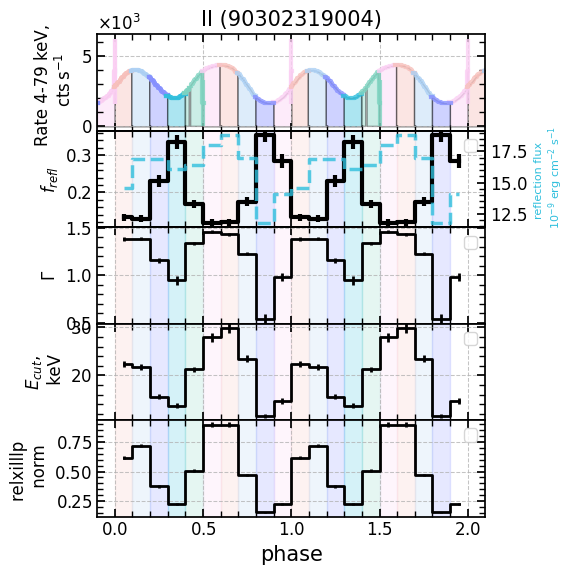

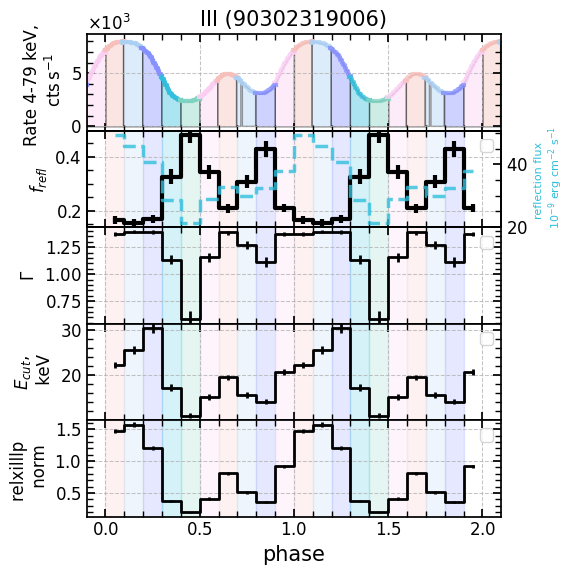

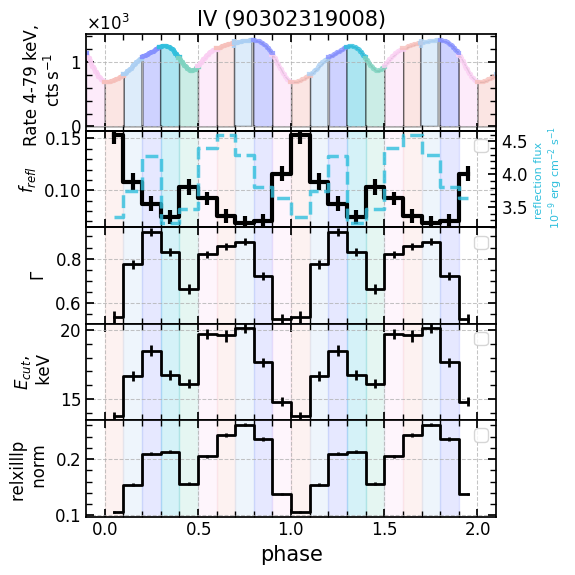

In [12]:
_, fig1 = plot_results(ObsList_bright[1]);

_, fig2 = plot_results(ObsList_bright[2]);

_, fig3 = plot_results(ObsList_bright[3]);

fig1.savefig(plot_path+ '/ph-res/high1.pdf')
fig2.savefig(plot_path+ '/ph-res/high2.pdf')
fig3.savefig(plot_path+ '/ph-res/high3.pdf')


In [4]:
# _, fig1 = plot_results(ObsList_bright[0]);

# _, fig2 = plot_results(ObsList_bright[4]);

# fig1.savefig(plot_path+ '/ph-res/low1.pdf')
# fig2.savefig(plot_path+ '/ph-res/low2.pdf')
